In [77]:
import random
import numpy as np


class Function:
    def __init__(self, value, delt=0.001):
        self.value = value

        def grad(x):
            array = []
            for i in range(len(x)):
                x[i] += delt
                first_val = value(x)
                x[i] -= 2 * delt
                second_val = value(x)
                x[i] += delt
                array.append((first_val - second_val) / (2 * delt))
            return np.array(array)

        self.grad = grad


wolfe_cond_template = lambda c1, c2, x, func, gk: lambda a, b: not (
        (func.value(x - ((a + b) / 2) * gk) <= (func.value(x) + c1 * ((a + b) / 2) * np.dot(gk, -gk))) and (
        np.dot(func.grad(x - ((a + b) / 2) * gk), -gk) >= c2 * np.dot(gk, -gk)))

wolfe_cond = lambda: ""


def grad_desc(func, lr, x, eps, is_wolfe=False, left_wolfe_bound=0.1, right_wolfe_bound=0.9, need_points=True,
              max_num_of_step=1000):
    global wolfe_cond
    num_of_steps = 0
    points = [x]
    while True:
        prev_x = x
        grad = func.grad(x)
        if is_wolfe:
            wolfe_cond = wolfe_cond_template(left_wolfe_bound, right_wolfe_bound, x, func, grad)
        x = x - lr(Function(lambda a: func.value(x - a * grad)), is_wolfe) * grad
        if need_points:
            points.append(x)
        else:
            points = [x]
        num_of_steps += 1
        if abs(func.value(x) - func.value(prev_x)) < eps or num_of_steps >= max_num_of_step:
            break

    if need_points: return np.array(points)
    return (points[0], num_of_steps)


def right_border_calc(func):
    right_start = 0.0000001
    zero = func.value(0)
    while zero >= func.value(right_start):
        right_start *= 2

    return right_start


def dichotomy(func, a_1, a_2, eps, delt, is_wolfe=False):
    cond = lambda a, b: abs(a - b) >= eps
    if is_wolfe:
        cond = wolfe_cond
    while cond(a_1, a_2):
        new_a_1 = (a_1 + a_2) / 2 - delt
        new_a_2 = (a_1 + a_2) / 2 + delt
        fv1 = func.value(new_a_1)
        fv2 = func.value(new_a_2)
        if fv2 > fv1:
            a_2 = new_a_2
        elif fv2 < fv1:
            a_1 = new_a_1
        else:
            a_1 = new_a_1
            a_2 = new_a_2
    return (a_1 + a_2) / 2


def func_generator(n, k):
    vals = [random.uniform(1.0, k) for _ in range(n)]
    vals.sort()
    vals[0] = 1
    vals[n - 1] = k
    q, r = np.linalg.qr(np.random.rand(n, n))
    matr = np.matmul(np.matmul(q, np.diag(vals)), np.transpose(q))
    return matr


class GeneratedFunctionCalculator(Function):
    def __init__(self, matr):
        super().__init__(lambda x: sum(matr[i][j] * x[i] * x[j] for i in range(len(x)) for j in range(len(x))))
        self.matr = matr

In [78]:
import matplotlib.pyplot as plt


def lr_wrapper(eps, delt):
    return lambda func, is_wolfe=False: dichotomy(func, 0, right_border_calc(func), eps, delt, is_wolfe)


def func1(x):
    return (x[0] - 2) ** 2 + 3 * (9 - x[1]) ** 2


def func2(x):
    return 20 * (x[0] - 5) ** 2 + (x[1] - 3) ** 2


def func3(x):
    return (x[0] - 5) ** 2 + (x[1] - 4) ** 2


def visualise_points(func, points, title=""):
    XX = np.linspace(min(points[-1][0], points[0][0]) - 30, max(points[-1][0], points[0][0]) + 30, 500)
    YY = np.linspace(min(points[-1][1], points[0][1]) - 30, max(points[-1][1], points[0][1]) + 30, 500)
    X, Y = np.meshgrid(XX, YY)
    plt.contour(X, Y, func.value([X, Y]), 20)

    plt.plot(points[:, 0], points[:, 1], marker='.')
    plt.plot(points[0][0], points[0][1], 'og')
    plt.plot(points[-1][0], points[-1][1], 'or')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.show()


functions = [Function(func) for func in [func1, func2, func3]]

### 4(a) Сходимость с постоянным шагом

Const rate: 0.01 | Start x: [13. 24.] | Epsilon: 0.0001
Count steps: 269
Final point: [2.04897574 9.00000094]


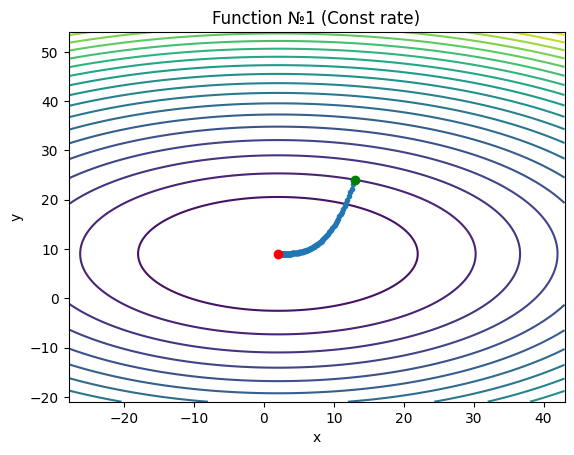


Const rate: 0.01 | Start x: [13. 24.] | Epsilon: 0.0001
Count steps: 301
Final point: [5.         3.04898262]


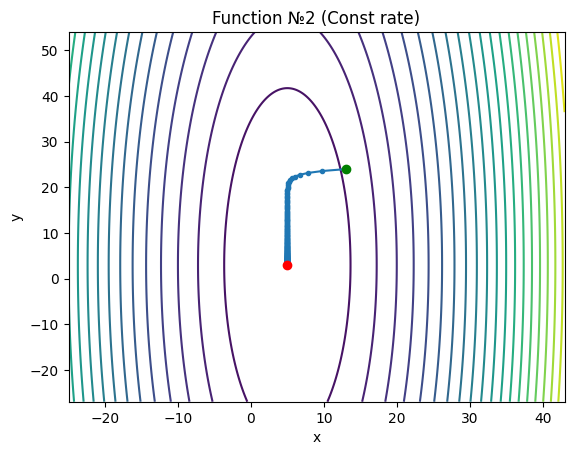


Const rate: 0.01 | Start x: [13. 24.] | Epsilon: 0.0001
Count steps: 302
Final point: [5.01828684 4.04571711]


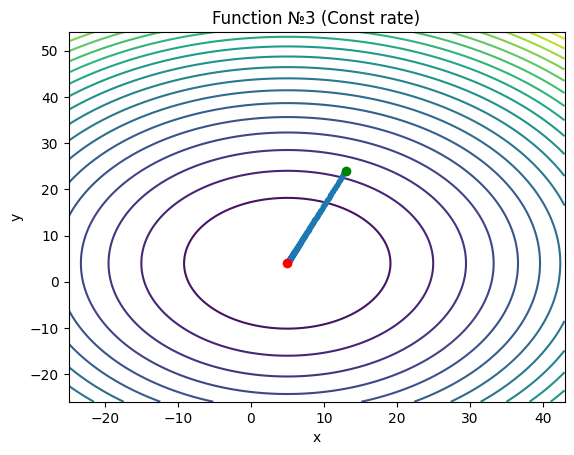

In [79]:
def test_convergence_const_lr(func, name):
    lr = 0.01
    eps = 0.0001
    x = np.array((13., 24.))

    print('Const rate: ' + str(lr) + ' | Start x: ' + str(x) + ' | Epsilon: ' + str(eps))
    points = grad_desc(func, lambda *_: lr, x, eps)
    print('Count steps: ' + str(len(points)))
    print('Final point: ' + str(points[-1]))
    visualise_points(func, points, name + ' (Const rate)')
    print()


for i in range(len(functions)):
    test_convergence_const_lr(functions[i], 'Function №' + str(i + 1))

### 4(b) Сравнение количества

Const rate: 0.01 | Start x: [13. 24.] | Epsilon: 0.001
Count steps with const rate: 212
Final point with const rate: [2.15491542 9.00003207]


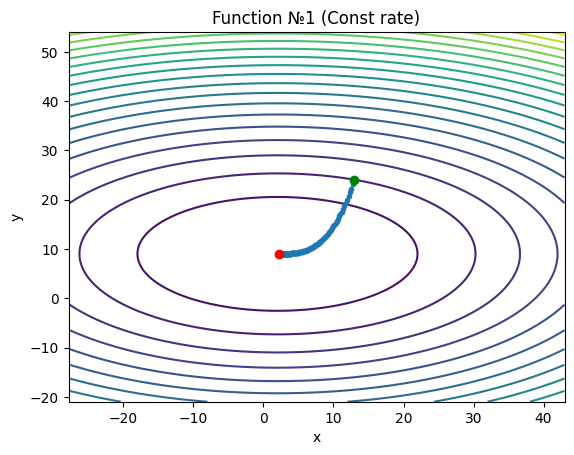

Start x: [13. 24.] | Epsilon: 0.001 | Delta: 0.0001
Count steps with dichotomy: 7
Final point with dichotomy: [2.0030252  9.00419789]


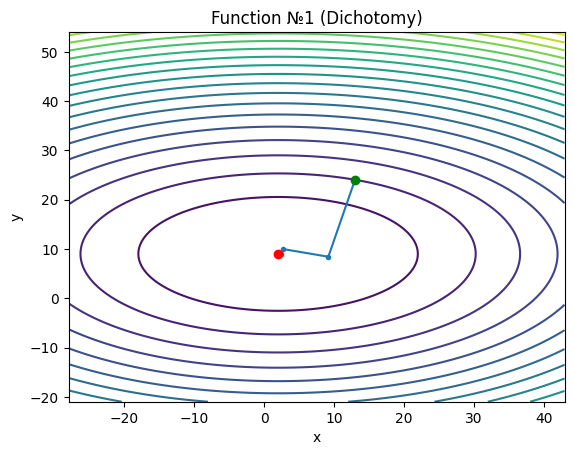

Start x: [13. 24.] Epsilon: 0.001 | Delta: 0.0001
Count steps with dichotomy(Wolfe): 10
Final point with dichotomy(Wolfe): [2.00635002 8.997354  ]


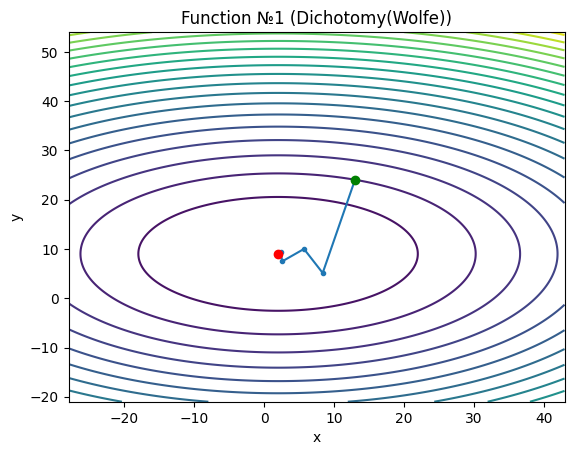


Const rate: 0.01 | Start x: [13. 24.] | Epsilon: 0.001
Count steps with const rate: 244
Final point with const rate: [5.         3.15493719]


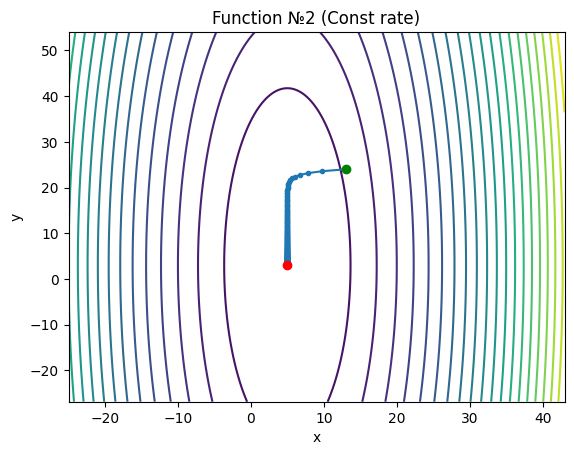

Start x: [13. 24.] | Epsilon: 0.001 | Delta: 0.0001
Count steps with dichotomy: 17
Final point with dichotomy: [5.00409526 3.01796712]


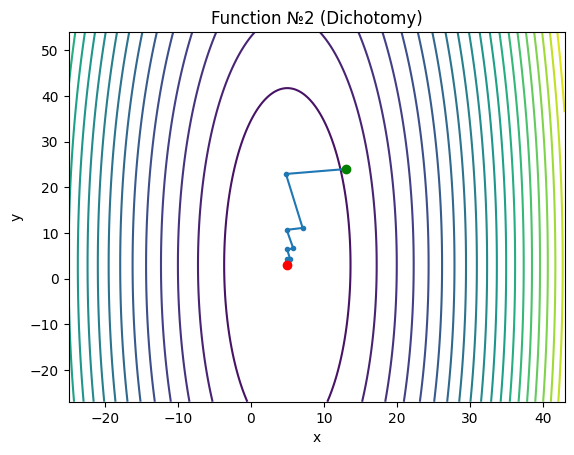

Start x: [13. 24.] Epsilon: 0.001 | Delta: 0.0001
Count steps with dichotomy(Wolfe): 20
Final point with dichotomy(Wolfe): [4.9996946  3.00873795]


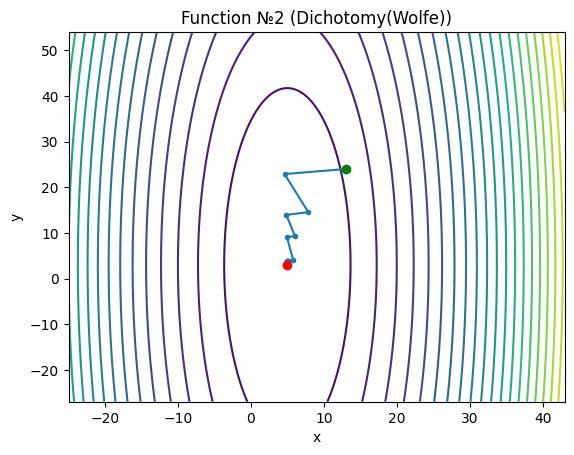


Const rate: 0.01 | Start x: [13. 24.] | Epsilon: 0.001
Count steps with const rate: 246
Final point with const rate: [5.05668635 4.14171589]


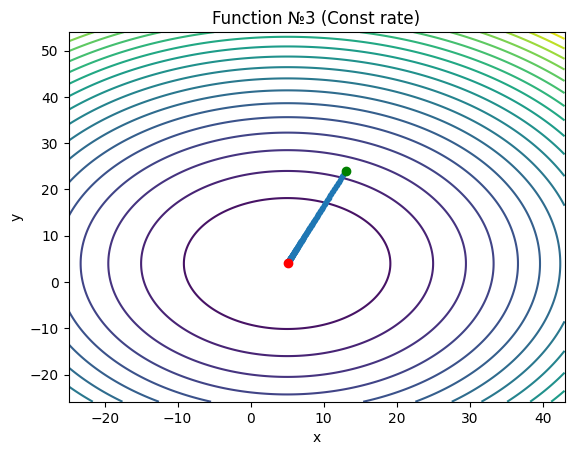

Start x: [13. 24.] | Epsilon: 0.001 | Delta: 0.0001
Count steps with dichotomy: 3
Final point with dichotomy: [5.00000006 4.00000015]


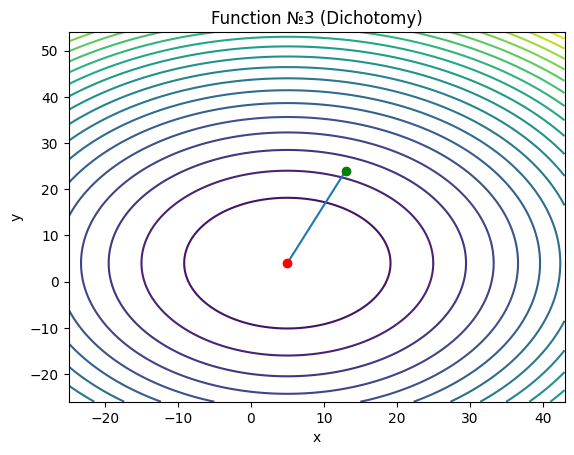

Start x: [13. 24.] Epsilon: 0.001 | Delta: 0.0001
Count steps with dichotomy(Wolfe): 18
Final point with dichotomy(Wolfe): [4.98926103 3.97315258]


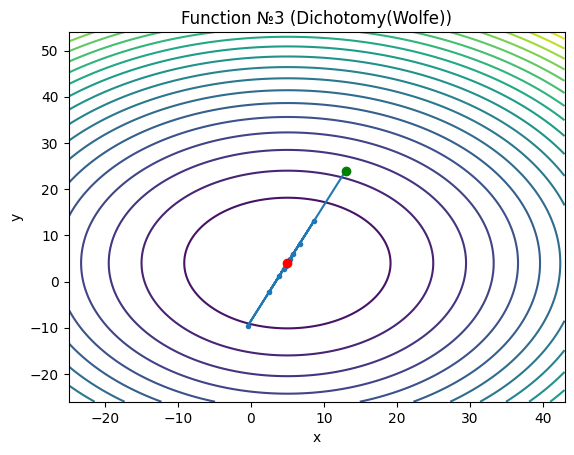

In [80]:
def compare_count_calculations(func, name):
    lr = 0.01
    eps = 0.001
    delt = 0.0001
    x = np.array((13., 24.))

    print('Const rate: ' + str(lr) + ' | Start x: ' + str(x) + ' | Epsilon: ' + str(eps))
    points_const_lr = grad_desc(func, lambda *_: lr, x, eps)
    print('Count steps with const rate: ' + str(len(points_const_lr)))
    print('Final point with const rate: ' + str(points_const_lr[-1]))
    visualise_points(func, points_const_lr, name + ' (Const rate)')

    print('Start x: ' + str(x) + ' | Epsilon: ' + str(eps) + ' | Delta: ' + str(delt))
    points_dichotomy = grad_desc(func, lr_wrapper(eps, delt), x, eps)
    print('Count steps with dichotomy: ' + str(len(points_dichotomy)))
    print('Final point with dichotomy: ' + str(points_dichotomy[-1]))
    visualise_points(func, points_dichotomy, name + ' (Dichotomy)')

    print('Start x: ' + str(x) + ' Epsilon: ' + str(eps) + ' | Delta: ' + str(delt))
    points_dichotomy_wolfe = grad_desc(func, lr_wrapper(eps, delt), x, eps, is_wolfe=True)
    print('Count steps with dichotomy(Wolfe): ' + str(len(points_dichotomy_wolfe)))
    print('Final point with dichotomy(Wolfe): ' + str(points_dichotomy_wolfe[-1]))
    visualise_points(func, points_dichotomy_wolfe, name + ' (Dichotomy(Wolfe))')
    print()


for i in range(len(functions)):
    compare_count_calculations(functions[i], 'Function №' + str(i + 1))

### 4(c) Тест на разные начальные точки

Const rate: 0.01 | Start x: [13. 22.] | Epsilon: 0.001
Count steps with const rate: 212
Final point with const rate: [2.15491542 9.00002779]


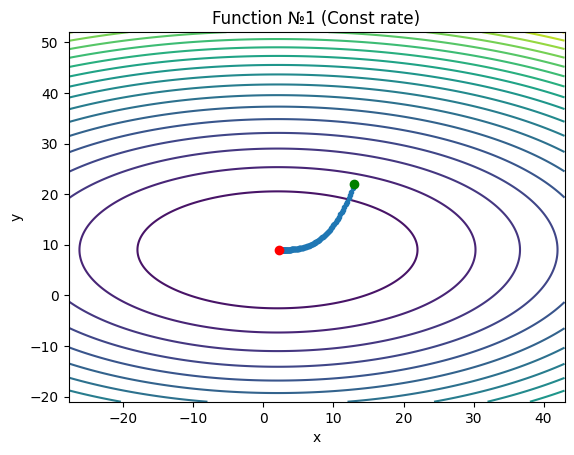

Start x: [13. 22.] | Epsilon: 0.001 | Delta: 0.0001
Count steps with dichotomy: 8
Final point with dichotomy: [2.00389557 8.99964996]


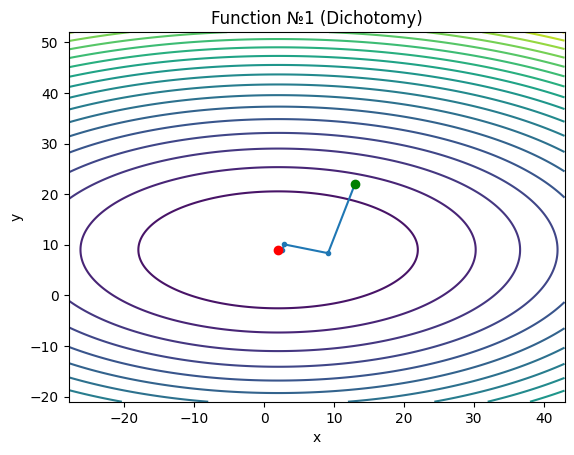


Const rate: 0.01 | Start x: [-5. 11.] | Epsilon: 0.001
Count steps with const rate: 190
Final point with const rate: [1.84624603 9.00001668]


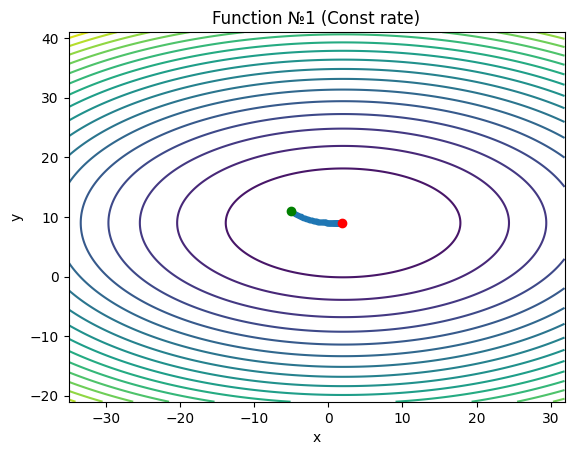

Start x: [-5. 11.] | Epsilon: 0.001 | Delta: 0.0001
Count steps with dichotomy: 10
Final point with dichotomy: [1.98821563 8.99545555]


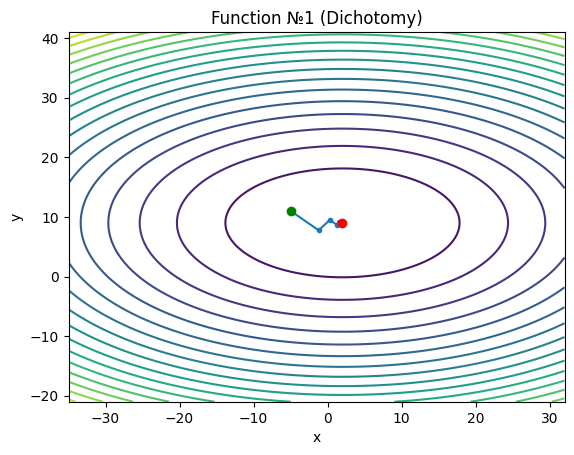


Const rate: 0.01 | Start x: [13. 22.] | Epsilon: 0.001
Count steps with const rate: 239
Final point with const rate: [5.         3.15508137]


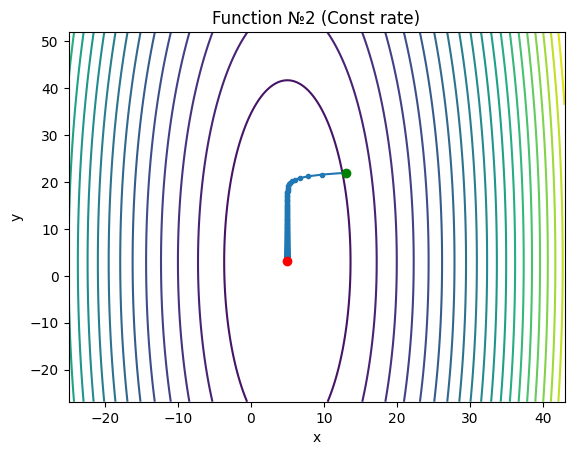

Start x: [13. 22.] | Epsilon: 0.001 | Delta: 0.0001
Count steps with dichotomy: 9
Final point with dichotomy: [5.00193266 3.00459455]


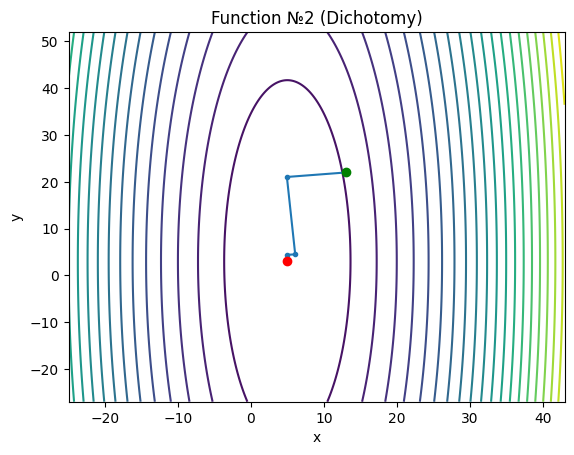


Const rate: 0.01 | Start x: [-5. 11.] | Epsilon: 0.001
Count steps with const rate: 196
Final point with const rate: [5.         3.15565918]


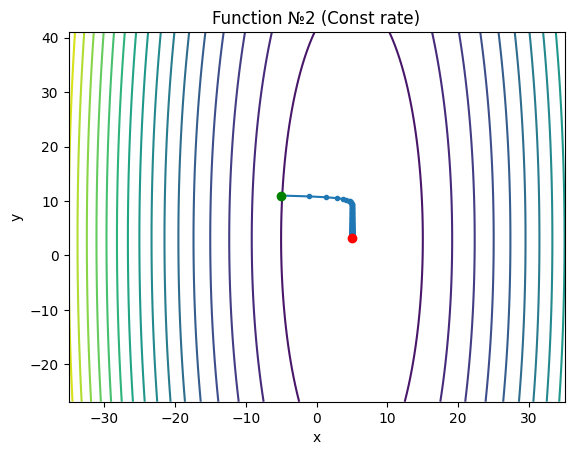

Start x: [-5. 11.] | Epsilon: 0.001 | Delta: 0.0001
Count steps with dichotomy: 15
Final point with dichotomy: [4.9959265 3.0166698]


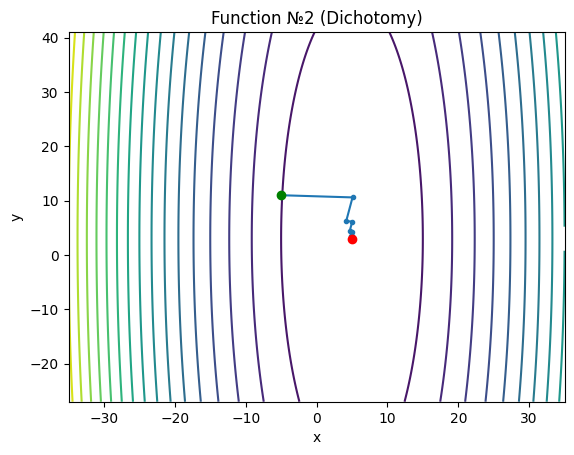


Const rate: 0.01 | Start x: [13. 22.] | Epsilon: 0.001
Count steps with const rate: 241
Final point with const rate: [5.06271164 4.14110119]


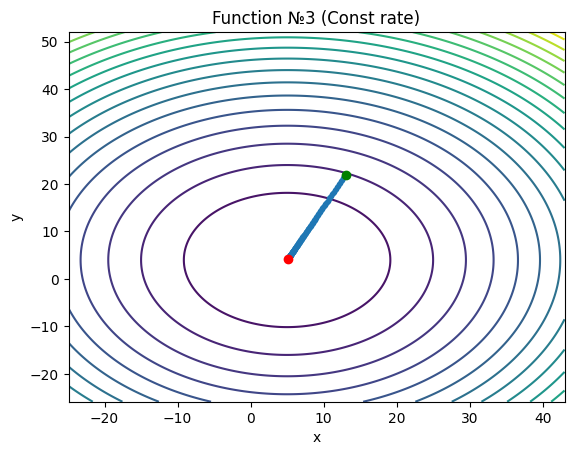

Start x: [13. 22.] | Epsilon: 0.001 | Delta: 0.0001
Count steps with dichotomy: 3
Final point with dichotomy: [5.00000006 4.00000013]


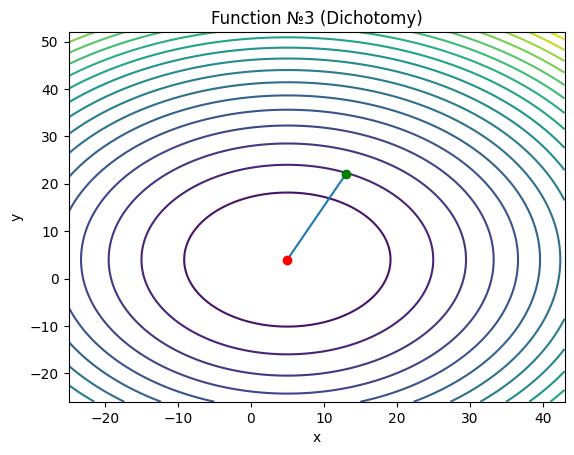


Const rate: 0.01 | Start x: [-5. 11.] | Epsilon: 0.001
Count steps with const rate: 217
Final point with const rate: [4.87269884 4.08911081]


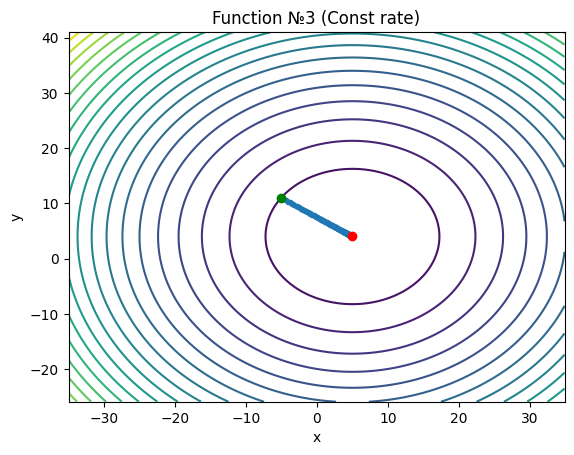

Start x: [-5. 11.] | Epsilon: 0.001 | Delta: 0.0001
Count steps with dichotomy: 3
Final point with dichotomy: [4.99999993 4.00000005]


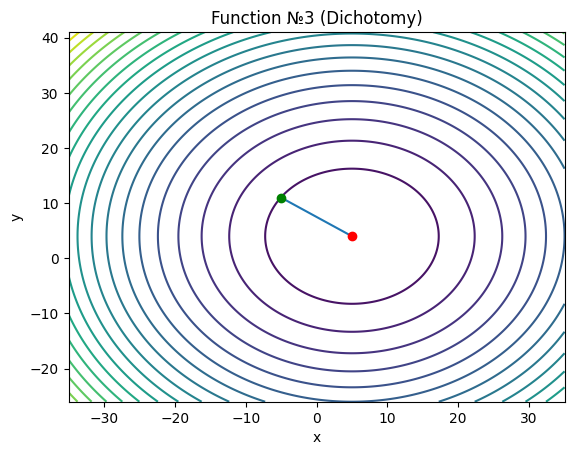

In [81]:
def test_different_start_points(func, name):
    start_x = [np.array(x) for x in [(13., 22.), (-5., 11.)]]
    for x in start_x:
        lr = 0.01
        eps = 0.001
        delt = 0.0001

        print('Const rate: ' + str(lr) + ' | Start x: ' + str(x) + ' | Epsilon: ' + str(eps))
        points_const_lr = grad_desc(func, lambda *_: lr, x, eps)
        print('Count steps with const rate: ' + str(len(points_const_lr)))
        print('Final point with const rate: ' + str(points_const_lr[-1]))
        visualise_points(func, points_const_lr, name + ' (Const rate)')

        print('Start x: ' + str(x) + ' | Epsilon: ' + str(eps) + ' | Delta: ' + str(delt))
        points_dichotomy = grad_desc(func, lr_wrapper(eps, delt), x, eps)
        print('Count steps with dichotomy: ' + str(len(points_dichotomy)))
        print('Final point with dichotomy: ' + str(points_dichotomy[-1]))
        visualise_points(func, points_dichotomy, name + ' (Dichotomy)')
        print()


for i in range(len(functions)):
    test_different_start_points(functions[i], 'Function №' + str(i + 1))

### 4(d) Исследование влияния нормализации

In [82]:
def test_scaling(func, name):
    func_scale = Function(lambda x: func.value(np.array([x[0], 1.5 ** x[1]])))
    eps = 0.001
    delt = 0.0001
    x = np.array((13., 24.))

    print(name)
    print('Epsilon: ' + str(eps) + ' | Delta: ' + str(delt))
    res_func = grad_desc(func, lr_wrapper(eps, delt), x, eps, need_points=False)
    print('Count steps of usual function: ' + str(res_func[1]) + ' value in point: ' + str(res_func[0]))
    res_scaling_func = grad_desc(func_scale, lr_wrapper(eps, delt), x, eps, need_points=False)
    print('Count steps of scaling function: ' + str(res_scaling_func[1]) + ' value in point: ' + str(
        res_scaling_func[0]))
    print()

generated_functions = [GeneratedFunctionCalculator(func_generator(2, k)) for k in range(10000, 10003)]
for i in range(len(generated_functions)):
    test_scaling(generated_functions[i], 'Generated Function №' + str(i + 1))

Generated Function №1
Epsilon: 0.001 | Delta: 0.0001
Count steps of usual function: 88 value in point: [14.63021412  2.94356488]
Count steps of scaling function: 7 value in point: [ 1.61265626e-05 -1.01522553e+09]

Generated Function №2
Epsilon: 0.001 | Delta: 0.0001
Count steps of usual function: 77 value in point: [ 2.37281862 22.60215892]
Count steps of scaling function: 6 value in point: [-3.11149513e-07 -6.50702877e+05]

Generated Function №3
Epsilon: 0.001 | Delta: 0.0001
Count steps of usual function: 58 value in point: [16.71994831 18.97410267]
Count steps of scaling function: 11 value in point: [ 5.55050237e-05 -5.14800978e+07]



### 6 Исследование зависимости числа итераций от размерности пространства и числа обусловленности функции

In [ ]:
from_nk_to_num_of_steps = [[]]
x = []
y = []
z = []
cnst = 10
middle = 0
num_of_steps = 0
for n in range(2, 1001):
    for k in range(1, 1001):
        if (k % cnst == 0 and n % cnst == 0):
            x.append(n)
            y.append(k)
            z.append(grad_desc(
                func=GeneratedFunctionCalculator(func_generator(n, k)),
                lr=lr_wrapper(0.01, 0.001),
                x=np.array([20., 20.]), eps=0.1, need_points=False)[1])
            middle += z[len(z) - 1]
            num_of_steps += 1

print(middle / num_of_steps)
x = np.asarray(x)
y = np.asarray(y)
z = np.asarray(z)
ax = plt.axes(projection='3d')
ax.grid()
ax.plot_trisurf(x, y, z, cmap='viridis', edgecolor='none')
# plt.figure().set_size_inches()
ax.figure.set_size_inches(15, 15)
plt.show()